In [1]:
from graph_tool.all import *
import graph_tool.all as gt
import numpy as np
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import scipy as sp
import pandas as pd
from tqdm import tqdm
from decimal import Decimal

Node = 1000
m = 2
times = 100
M_list = [4, 8, 10, 20]
beta_list = [1, 0.5, 0, -1, -3, -5, -10, -100]
w_list = [Decimal("0.00"), Decimal("0.50"), Decimal("0.70"), Decimal("0.90"), Decimal("0.95"), Decimal("0.98")]

In [3]:
for M in M_list:
    for beta in beta_list:
        records = []
        for W in w_list:
            Q_list = []
            path_list = []
            for i in tqdm(range(times)):
                g = gt.load_graph(f"~/o_t_hayashilab/network_data/graph-tool/modular_network/N={Node}/m={m}/beta={beta}/w={W}/Mo={M}/{i}.gt.gz")
                # 最大連結成分で計算
                l = gt.label_largest_component(g)
                u = gt.GraphView(g, vfilt=l)
                # モジュラリティ
                state = gt.BlockState(g, b=g.vp.module_number)
                Q = gt.modularity(g, state.get_blocks())
                Q_list.append(Q)
                # 平均経路長
                dist_mat = gt.shortest_distance(u)
                dists = np.array(dist_mat.get_2d_array(range(u.num_vertices())))
                finite_dists = dists[np.isfinite(dists) & (dists > 0)]
                if len(finite_dists) > 0:
                    avg_path = np.mean(finite_dists)
                else:
                    avg_path = np.nan
                path_list.append(avg_path)
            for q, p in zip(Q_list, path_list):
                records.append({"modularity": q, "path_length": p, "w": float(W)})
        df = pd.DataFrame(records)
        df.to_csv(f"mo{M}_beta{beta}_modularity_vs_pathlength.csv", index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] そのようなファイルやディレクトリはありません: '/home/guest/o_t_hayashilab/network_data/graph-tool/modular_network/N=1000/m=2/beta=1/w=0.00/Mo=4/0.gt.gz'

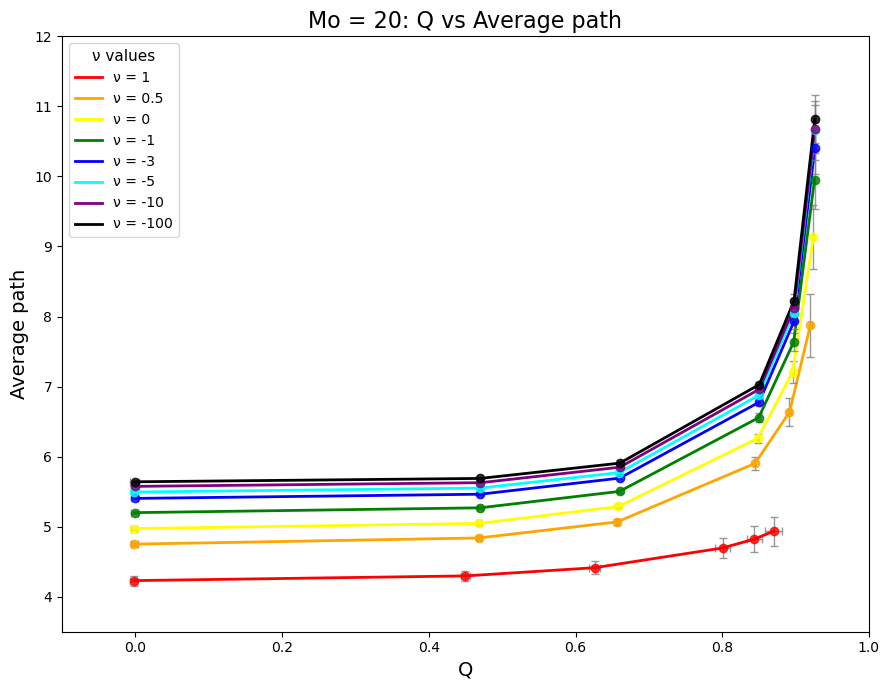

In [6]:
color_list = [
    "red",       # β = 1
    "orange",    # β = 0.5
    "yellow",    # β = 0
    "green",     # β = -1
    "blue",      # β = -3
    "cyan",      # β = -5
    "purple",    # β = -10
    "black",     # β = -100
]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# betaのリストと色の固定対応
beta_list = [1, 0.5, 0, -1, -3, -5, -10, -100]
color_list = ["red", "orange", "yellow", "green", "blue", "cyan", "purple", "black"]
color_map = dict(zip(beta_list, color_list))

w_list = [0.00, 0.50, 0.70, 0.90, 0.95, 0.98]
Mo = 20

plt.figure(figsize=(9, 7))

for beta in beta_list:
    # mo=4
    df4 = pd.read_csv(f"~/o_t_hayashilab/network_code/result/mo{Mo}_beta{beta}_modularity_vs_pathlength.csv")
    means4 = df4.groupby("w").agg({"modularity": "mean", "path_length": "mean"})
    stds4 = df4.groupby("w").agg({"modularity": "std", "path_length": "std"})

    for w in w_list:
        sub = df4[df4["w"] == w]
        mean_mod = sub["modularity"].mean()
        mean_path = sub["path_length"].mean()
        std_mod = sub["modularity"].std()
        std_path = sub["path_length"].std()
        plt.errorbar(mean_mod, mean_path, xerr=std_mod, yerr=std_path,
                     fmt='o', color=color_map[beta], ecolor="gray", elinewidth=1, capsize=3, alpha=0.8)
        
    plt.plot(means4["modularity"], means4["path_length"], '-', linewidth=2, color=color_map[beta], label=f"ν = {beta}")

# 軸・タイトル・凡例など
plt.xlabel("Q", fontsize=14)
plt.ylabel("Average path", fontsize=14)
plt.title(f"Mo = {Mo}: Q vs Average path", fontsize=16)
plt.xlim(-0.1, 1.0)
plt.ylim(3.5, 12)
plt.legend(title="ν values", fontsize=10, title_fontsize=11, loc="upper left")
plt.grid(False)
plt.tight_layout()
plt.show()